# EDA Summary ver 1.0

In [36]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import argparse

from pyspark.sql.functions import col , regexp_replace, when, trim , regexp_extract, col , lit
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import matplotlib.pyplot as plt
import pandas as pd

In [37]:
# Start Spark session
spark = SparkSession.builder \
    .appName("DropOutliersExample") \
    .getOrCreate()

def drop_outliers_via_boxplot(df, column, spark, return_spark_df=True):
    # Ensure column is float
    df = df.withColumn(column, col(column).cast(FloatType()))
    
    # Convert to pandas
    pdf = df.select(column).toPandas()
    pdf[column] = pd.to_numeric(pdf[column], errors='coerce')
    pdf = pdf.dropna(subset=[column])
    
    # Compute IQR bounds
    Q1 = pdf[column].quantile(0.25)
    Q3 = pdf[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"\nIQR bounds for '{column}': {lower_bound:.2f} to {upper_bound:.2f}")
    
    # Print original min and max
    print(f"Original {column} range: min = {pdf[column].min():.2f}, max = {pdf[column].max():.2f}")
    
    # Filter Pandas before plotting
    filtered_pdf = pdf[(pdf[column] >= lower_bound) & (pdf[column] <= upper_bound)]

    # Print filtered min and max
    print(f"Filtered {column} range: min = {filtered_pdf[column].min():.2f}, max = {filtered_pdf[column].max():.2f}")
    
    # Plot side-by-side boxplots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(pdf[column], vert=True)
    plt.title(f"Before Filtering")
    plt.ylabel(column)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.boxplot(filtered_pdf[column], vert=True)
    plt.title(f"After Filtering (IQR)")
    plt.grid(True)

    plt.suptitle(f"Boxplot Comparison: {column}")
    plt.tight_layout()
    plt.show()
    
    # Filter Spark DataFrame
    filtered_spark = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    return filtered_spark if return_spark_df else filtered_pdf

25/05/17 15:32:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## EDA - Boxplot Comparrison (Before and after IQR) : Annual_Income


IQR bounds for 'Annual_Income': -53630.50 to 148190.90
Original Annual_Income range: min = 7630.57, max = 17655552.00
Filtered Annual_Income range: min = 7630.57, max = 147620.69


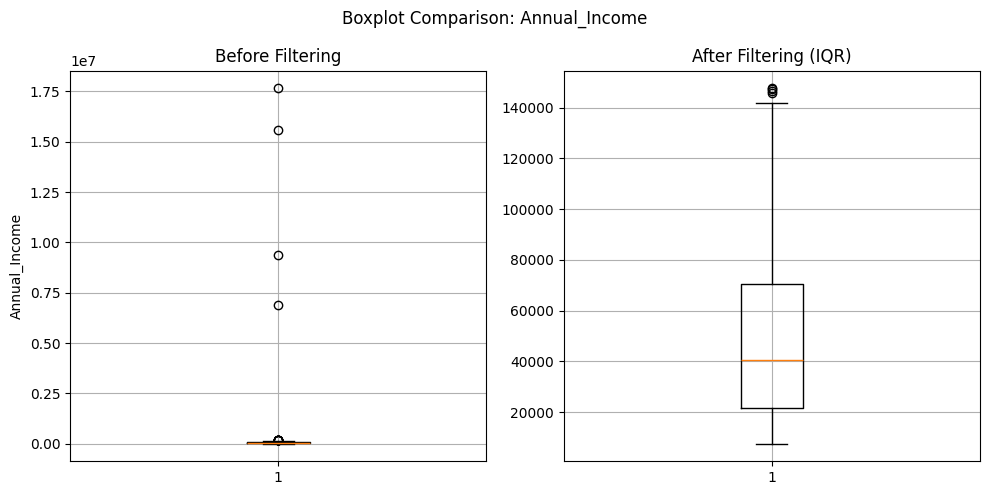

In [38]:
# Annual_Income
path = "../datamart/bronze/features_financials/bronze_features_financials_2024_12_01.csv"

# Read CSV correctly
df = spark.read.csv(path, header=True, inferSchema=True)

# Now run the drop_outliers function
cleaned_df = drop_outliers_via_boxplot(df, "Annual_Income", spark)
#cleaned_df.show(10)

## EDA - Boxplot Comparrison (Before and after IQR) : Num_Credit_Inquiries


IQR bounds for 'Num_Credit_Inquiries': -3.50 to 16.50
Original Num_Credit_Inquiries range: min = 0.00, max = 1549.00
Filtered Num_Credit_Inquiries range: min = 0.00, max = 16.00


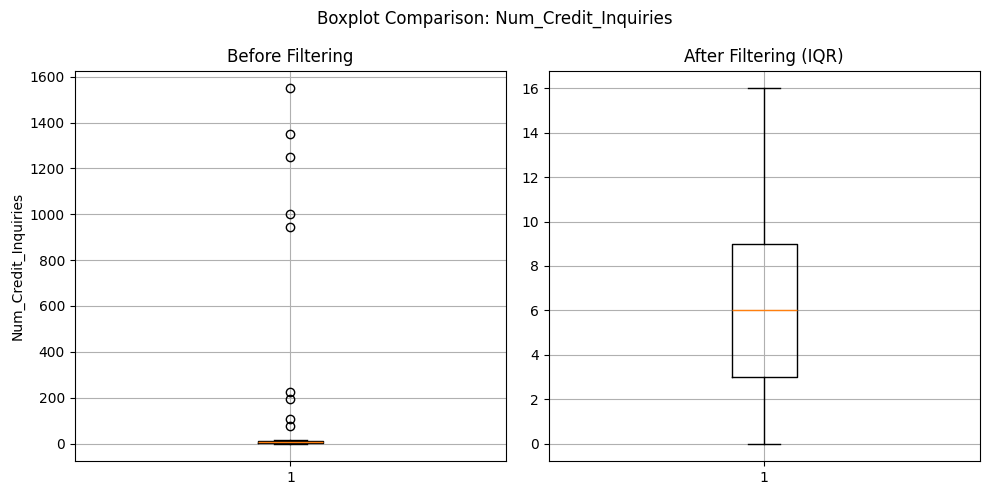

In [39]:
# Num_Credit_Inquiries
path = "../datamart/bronze/features_financials/bronze_features_financials_2024_12_01.csv"

# Read CSV correctly
df = spark.read.csv(path, header=True, inferSchema=True)

# Now run the drop_outliers function
cleaned_df = drop_outliers_via_boxplot(df, "Num_Credit_Inquiries", spark)
#cleaned_df.show(10)

In [40]:
import os

parquet_dir = "../datamart/silver/features/"
valid_parquet_files = [os.path.join(parquet_dir, f) 
                       for f in os.listdir(parquet_dir) 
                       if f.endswith(".parquet")]

#print("Found Parquet files:")
#for f in valid_parquet_files:
    #print(f)
if not valid_parquet_files:
    raise ValueError("No valid Parquet files found in directory!")

# Read all valid parquet files
df = spark.read.parquet(*valid_parquet_files)

## EDA - Occupation Distribution (from all Bronze Parquet files)

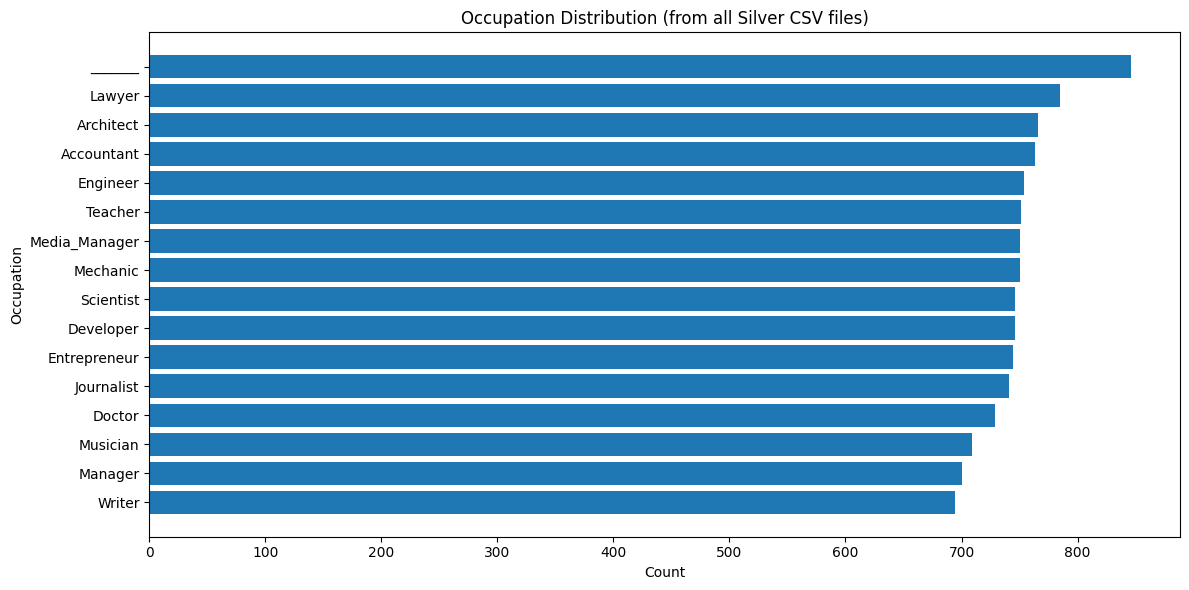

Accountant
Architect
Developer
Doctor
Engineer
Entrepreneur
Journalist
Lawyer
Manager
Mechanic
Media_Manager
Musician
Scientist
Teacher
Writer
_______


In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. List all CSV files
csv_dir = "../datamart/bronze/features_attributes/"
valid_csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith(".csv")]

# 2. Read and combine all CSV files into a single DataFrame
df = pd.concat([pd.read_csv(f) for f in valid_csv_files], ignore_index=True)

# 3. Drop rows where Occupation is missing
df_filtered = df[df["Occupation"].notna()]

# 4. Count occupation frequencies
occupation_counts = df_filtered["Occupation"].value_counts()

# 5. Plot
plt.figure(figsize=(12, max(6, len(occupation_counts) * 0.25)))
plt.barh(occupation_counts.index, occupation_counts.values)
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.title("Occupation Distribution (from all Silver CSV files)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

unique_occupations = sorted(df_filtered["Occupation"].unique())
for occ in unique_occupations:
    print(occ)
